In [42]:
import pandas as pd
import os

print("--- RE-PROCESANDO DATOS (MODO CORRECCIÓN DE COLUMNAS) ---")

archivos = ['sri_recaudacion_2020.csv', 'sri_recaudacion_2021.csv', 
            'sri_recaudacion_2022.csv', 'sri_recaudacion_2023.csv', 
            'sri_recaudacion_2024.csv']

lista_dfs = []

for archivo in archivos:
    if os.path.exists(archivo):
        try:
            # Leemos el archivo
            df_temp = pd.read_csv(archivo, sep='|', encoding='latin-1', dtype=str, on_bad_lines='skip')
            
            # --- CORRECCIÓN CLAVE AQUÍ ---
            # 1. Limpiamos nombres de columnas (quitamos espacios y caracteres raros como ï»¿)
            df_temp.columns = df_temp.columns.str.replace('ï»¿', '', regex=False)
            df_temp.columns = df_temp.columns.str.strip() # Quita espacios al inicio/final
            
            # 2. Convertimos PROVINCIA para filtrar
            df_temp['PROVINCIA'] = df_temp['PROVINCIA'].astype(str).str.upper().str.strip()
            
            # 3. Filtramos
            filtro = df_temp['PROVINCIA'].str.contains('LOJA', na=False)
            df_loja = df_temp[filtro].copy()
            
            print(f" -> {archivo}: {len(df_loja)} registros. (Columnas: {list(df_loja.columns[:3])}...)")
            
            if len(df_loja) > 0:
                lista_dfs.append(df_loja)

        except Exception as e:
            print(f" [ERROR] {archivo}: {e}")

# UNIFICACIÓN
if lista_dfs:
    df_final = pd.concat(lista_dfs, ignore_index=True)

    # Limpieza de valores
    df_final['VALOR_RECAUDADO'] = df_final['VALOR_RECAUDADO'].str.replace(',', '.', regex=False)
    df_final['VALOR_RECAUDADO'] = pd.to_numeric(df_final['VALOR_RECAUDADO'], errors='coerce')
    
    # AHORA SÍ: La columna ANIO ya debería llamarse igual en todos
    df_final['ANIO'] = pd.to_numeric(df_final['ANIO'], errors='coerce')

    # Guardar
    df_final.to_csv('Dataset_Loja_Final.csv', index=False)
    
    print("\n" + "="*40)
    print(" RESUMEN FINAL (Ahora deben salir todos los años)")
    print("="*40)
    print(df_final['ANIO'].value_counts().sort_index())
    
else:
    print("No se generaron datos.")

--- RE-PROCESANDO DATOS (MODO CORRECCIÓN DE COLUMNAS) ---
 -> sri_recaudacion_2020.csv: 31791 registros. (Columnas: ['ANIO', 'MES', 'GRUPO_IMPUESTO']...)
 -> sri_recaudacion_2021.csv: 37815 registros. (Columnas: ['ANIO', 'MES', 'GRUPO_IMPUESTO']...)
 -> sri_recaudacion_2022.csv: 37944 registros. (Columnas: ['ANIO', 'MES', 'GRUPO_IMPUESTO']...)
 -> sri_recaudacion_2023.csv: 34995 registros. (Columnas: ['ANIO', 'MES', 'GRUPO_IMPUESTO']...)
 -> sri_recaudacion_2024.csv: 33273 registros. (Columnas: ['ANIO', 'MES', 'GRUPO_IMPUESTO']...)

 RESUMEN FINAL (Ahora deben salir todos los años)
ANIO
2020    31791
2021    37815
2022    37944
2023    34995
2024    33273
Name: count, dtype: int64


In [43]:
# 1. Cargar el dataset actual
df = pd.read_csv('Dataset_Loja_Final.csv')

# --- FILTRO DE SEGURIDAD GEOGRÁFICA ---

# Lista Oficial de los 16 Cantones de la Provincia de Loja (DPA Oficial)
CANTONES_REALES_LOJA = [
    "LOJA",
    "CALVAS",
    "CATAMAYO",
    "CELICA",
    "CHAGUARPAMBA",
    "ESPINDOLA",    # A veces viene sin tilde en sistemas antiguos
    "ESPÍNDOLA",    # Con tilde por si acaso
    "GONZANAMA",
    "GONZANAMÁ",
    "MACARA",
    "MACARÁ",
    "PALTAS",
    "PUYANGO",
    "SARAGURO",
    "SOZORANGA",
    "ZAPOTILLO",
    "PINDAL",
    "QUILANGA",
    "OLMEDO"
]

# 1. Normalizamos la columna CANTON del dataframe (Mayúsculas y sin espacios extra)
df['CANTON'] = df['CANTON'].astype(str).str.upper().str.strip()

# 2. Identificamos qué cantones NO pertenecen antes de borrarlos (Para tu reporte)
cantones_erroneos = df[~df['CANTON'].isin(CANTONES_REALES_LOJA)]['CANTON'].unique()

if len(cantones_erroneos) > 0:
    print("⚠️ ALERTA: Se encontraron y eliminarán estos cantones ajenos a Loja:")
    print(cantones_erroneos)
else:
    print("✅ Verificación exitosa: Todos los cantones pertenecen a Loja.")

# 3. APLICAMOS EL FILTRO (Solo dejamos los que están en la lista oficial)
df_limpio_geo = df[df['CANTON'].isin(CANTONES_REALES_LOJA)].copy()

# 4. Guardamos el archivo corregido
df_limpio_geo.to_csv('Dataset_Loja_Final.csv', index=False)

print(f"\nRegistros antes del filtro: {len(df)}")
print(f"Registros después del filtro: {len(df_limpio_geo)}")
print(f"Diferencia eliminada: {len(df) - len(df_limpio_geo)}")

# --- CONTINÚA CON TU ANÁLISIS ---
# Ahora puedes volver a correr el código de estadísticas que te di antes
# usando df_limpio_geo

⚠️ ALERTA: Se encontraron y eliminarán estos cantones ajenos a Loja:
['QUITO' 'PAQUISHA' 'MACHALA' 'CENTINELA DEL CONDOR' 'LA MANA' 'GIRON'
 'RUMIÃ\x91AHUI' 'CHINCHIPE' 'NANGARITZA' 'PORTOVIEJO' 'HUAQUILLAS'
 'PORTOVELO' 'GUAYAQUIL' 'BALSAS' 'ZARUMA' 'PALANDA' 'CUENCA' 'GUALAQUIZA'
 'SANTA ISABEL' 'IBARRA' 'SANTA ROSA' 'SIGSIG' 'SANTO DOMINGO'
 'CAMILO PONCE ENRIQUEZ' 'RIOBAMBA' 'EL PANGUI' 'AZOGUES' 'TENA' 'LORETO'
 'ZAMORA' 'ARENILLAS' 'TULCAN' 'AMBATO' 'YANTZAZA' 'LAS LAJAS' 'VENTANAS'
 'YACUAMBI' 'AGUARICO' 'EL TAMBO' 'MANTA' 'MARCABELI' 'CAÃ\x91AR'
 'ATAHUALPA' 'BABAHOYO' 'CALUMA' 'LATACUNGA' 'PIÃ\x91AS' 'EL GUABO'
 'DURAN' 'PASAJE' 'SAMBORONDON' 'MORONA' 'ROCAFUERTE' 'LA TRONCAL'
 'OÃ\x91A' 'SHUSHUFINDI' 'SAN MIGUEL DE LOS BANCOS'
 'BAÃ\x91OS DE AGUA SANTA' 'COTACACHI' 'MILAGRO' 'LA JOYA DE LOS SACHAS'
 'ARCHIDONA' 'JARAMIJO' 'PEDRO MONCAYO' 'ESMERALDAS' 'ORELLANA' 'OTAVALO'
 'SAN PEDRO DE PELILEO' 'PALORA' 'DAULE' 'SAN JACINTO DE YAGUACHI'
 'CAYAMBE' 'LAGO AGRIO' 'QUININDE' 'CHO

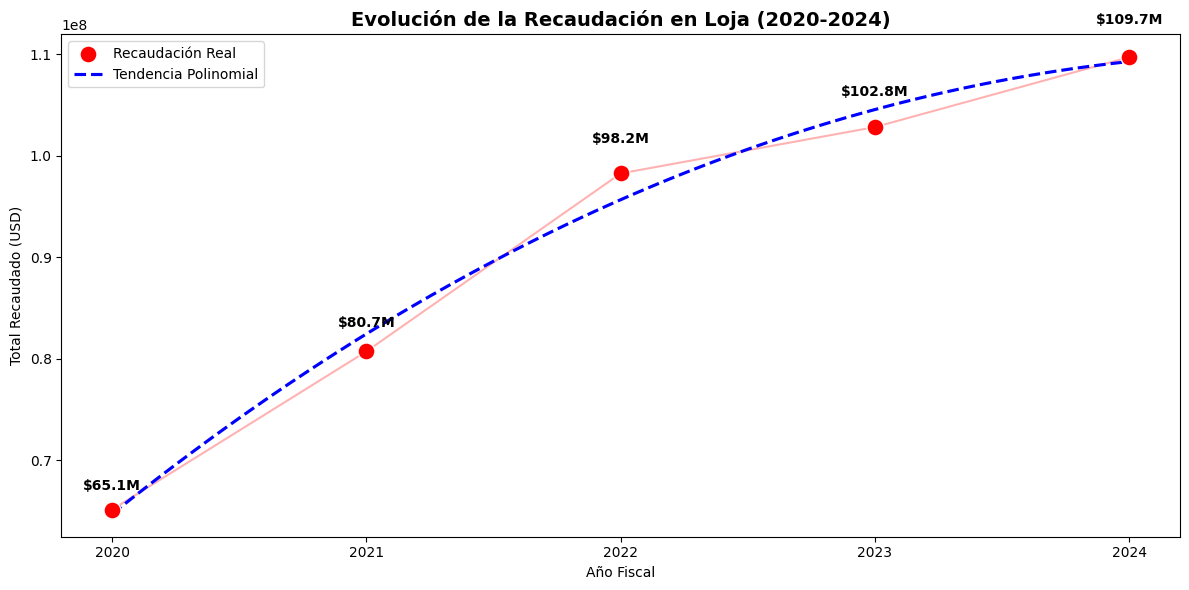

In [44]:
# Crear figura independiente
from matplotlib import pyplot as plt
# ...existing code...
import seaborn as sns
# ...existing code...

plt.figure(figsize=(12, 6))

# Agrupar datos por año
df_anual = df.groupby('ANIO')['VALOR_RECAUDADO'].sum().reset_index()

# 1. Puntos Rojos (Datos reales)
sns.scatterplot(data=df_anual, x='ANIO', y='VALOR_RECAUDADO', s=150, color='red', zorder=5, label='Recaudación Real')

# 2. Línea tenue roja (Conexión visual)
sns.lineplot(data=df_anual, x='ANIO', y='VALOR_RECAUDADO', color='red', alpha=0.3)

# 3. Tendencia Polinomial (Línea Azul Punteada)
# ci=None ELIMINA EL SOMBREADO
if len(df_anual) >= 3:
    sns.regplot(data=df_anual, x='ANIO', y='VALOR_RECAUDADO', scatter=False, order=3, 
                color='blue', ci=None, line_kws={'linestyle':'--'}, label='Tendencia Polinomial')

# Formato y Etiquetas
plt.title('Evolución de la Recaudación en Loja (2020-2024)', fontsize=14, fontweight='bold')
plt.ylabel('Total Recaudado (USD)')
plt.xlabel('Año Fiscal')
plt.xticks(df_anual['ANIO'].unique()) # Asegura que salgan todos los años
plt.legend()

# Etiquetas de texto encima de los puntos ($ Millones)
for i in range(len(df_anual)):
    row = df_anual.iloc[i]
    plt.text(row['ANIO'], row['VALOR_RECAUDADO']*1.03, 
             f"${row['VALOR_RECAUDADO']/1000000:.1f}M", 
             ha='center', fontweight='bold', color='black')

plt.tight_layout()
plt.show()

=== A. RESUMEN ESTADÍSTICO GENERAL ===
Total Registros: 167785
Recaudación Total (2020-2024): $455,889,043.35
Promedio por registro: $2,717.10
Desviación Estándar: 27,897.41
Coeficiente de Variación: 10.27 (Indica altísima dispersión si es > 1)
--------------------------------------------------
=== B. ANÁLISIS DEL SEGMENTO DE RECAUDACIÓN NULA ($0.00) ===
Cantidad de registros en $0.00: 45287
Porcentaje del dataset: 26.99%

Top 5 Impuestos que registran $0 con mayor frecuencia:
IMPUESTO
IVA MENSUAL                                                  13773
IVA SEMESTRAL                                                 6579
RENTA PERSONAS NATURALES                                      4399
RETENCIONES EN LA FUENTE                                      3357
IMPUESTO A LA RENTA SOBRE INGRESOS DE HERENCIAS Y LEGADOS     3141
Name: count, dtype: int64

% de Ceros por Tipo de Contribuyente:
TIPO_CONTRIBUYENTE
PERSONAS NATURALES    59.555722
SOCIEDADES            37.774637
NO TIENE               2.6

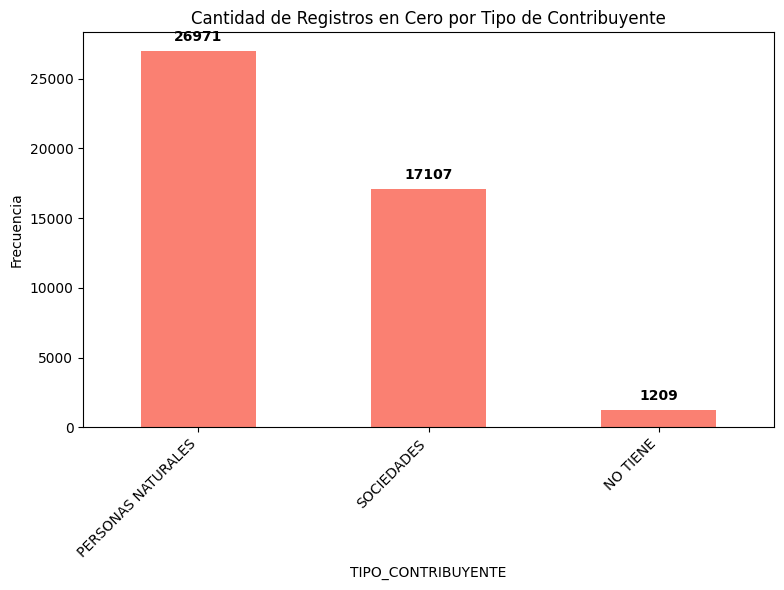

In [45]:
# 1. Cargar el dataset limpio
df = pd.read_csv('Dataset_Loja_Final.csv')

# Asegurar tipos de datos numéricos
df['VALOR_RECAUDADO'] = pd.to_numeric(df['VALOR_RECAUDADO'], errors='coerce')
df['ANIO'] = pd.to_numeric(df['ANIO'], errors='coerce')

# --- SECCIÓN A: ESTADÍSTICAS GENERALES Y DISPERSIÓN ---
print("=== A. RESUMEN ESTADÍSTICO GENERAL ===")
total_recaudado = df['VALOR_RECAUDADO'].sum()
promedio = df['VALOR_RECAUDADO'].mean()
desviacion = df['VALOR_RECAUDADO'].std()
coef_variacion = (desviacion / promedio) if promedio > 0 else 0

print(f"Total Registros: {len(df)}")
print(f"Recaudación Total (2020-2024): ${total_recaudado:,.2f}")
print(f"Promedio por registro: ${promedio:,.2f}")
print(f"Desviación Estándar: {desviacion:,.2f}")
print(f"Coeficiente de Variación: {coef_variacion:.2f} (Indica altísima dispersión si es > 1)")
print("-" * 50)

# --- SECCIÓN B: ANÁLISIS DE LOS "VALORES CERO" (El hallazgo del PDF) ---
print("=== B. ANÁLISIS DEL SEGMENTO DE RECAUDACIÓN NULA ($0.00) ===")
df_ceros = df[df['VALOR_RECAUDADO'] == 0]
porcentaje_ceros = (len(df_ceros) / len(df)) * 100

print(f"Cantidad de registros en $0.00: {len(df_ceros)}")
print(f"Porcentaje del dataset: {porcentaje_ceros:.2f}%")

# ¿Quiénes son los que no pagan? (Top 5 Impuestos con más ceros)
top_ceros_impuesto = df_ceros['IMPUESTO'].value_counts().head(5)
print("\nTop 5 Impuestos que registran $0 con mayor frecuencia:")
print(top_ceros_impuesto)

# ¿Qué tipo de contribuyente reporta más ceros?
top_ceros_contribuyente = df_ceros['TIPO_CONTRIBUYENTE'].value_counts(normalize=True) * 100
print("\n% de Ceros por Tipo de Contribuyente:")
print(top_ceros_contribuyente.head())
print("-" * 50)

# --- SECCIÓN C: SEGMENTACIÓN GEOGRÁFICA (LOJA VS RESTO) ---
print("=== C. CONCENTRACIÓN GEOGRÁFICA ===")
recaudacion_canton = df.groupby('CANTON')['VALOR_RECAUDADO'].sum().sort_values(ascending=False)
recaudacion_canton_pct = (recaudacion_canton / total_recaudado) * 100

print("Top 5 Cantones por % de Recaudación Total:")
print(recaudacion_canton_pct.head())
print("-" * 50)

# --- SECCIÓN D: EVOLUCIÓN TEMPORAL ---
print("=== D. EVOLUCIÓN ANUAL ===")
evolucion = df.groupby('ANIO')['VALOR_RECAUDADO'].sum()
print(evolucion.apply(lambda x: f"${x:,.2f}"))

# --- GRÁFICOS PARA EL INFORME ---
plt.figure(figsize=(15, 6))

# Gráfico 1: Barras con NÚMEROS
ax = plt.subplot(1, 2, 2)
conteo = df_ceros['TIPO_CONTRIBUYENTE'].value_counts().head(5)
conteo.plot(kind='bar', color='salmon', ax=ax)

plt.title('Cantidad de Registros en Cero por Tipo de Contribuyente')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')

# --- MAGIA: Añadir etiquetas de valor ---
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom', 
                xytext = (0, 5), 
                textcoords = 'offset points',
                fontsize=10, 
                fontweight='bold')

plt.tight_layout()
plt.show()

In [46]:
# Asegurar que los valores sean numéricos
df['VALOR_RECAUDADO'] = pd.to_numeric(df['VALOR_RECAUDADO'], errors='coerce')
df['ANIO'] = pd.to_numeric(df['ANIO'], errors='coerce')

# --- PARTE A: LISTADO EXACTO DE CANTONES ---
print("\n=== TABLA DE RECAUDACIÓN POR CANTÓN (2020-2024) ===")
# Agrupar por cantón y sumar el dinero real
cantones = df.groupby('CANTON')['VALOR_RECAUDADO'].agg(['sum', 'count']).sort_values(by='sum', ascending=False)
total_provincia = df['VALOR_RECAUDADO'].sum()

# Calcular porcentaje y dar formato
cantones['Participación'] = (cantones['sum'] / total_provincia) * 100
print(f"{'CANTÓN':<15} | {'TOTAL RECAUDADO (USD)':>20} | {'REGISTROS':>10} | {'%':>6}")
print("-" * 60)
for canton, row in cantones.iterrows():
    print(f"{canton:<15} | ${row['sum']:,.2f} | {int(row['count']):10d} | {row['Participación']:6.2f}%")

# --- PARTE B: ANÁLISIS DE CEROS (NÚMEROS EXACTOS) ---
print("\n" + "="*50)
print("=== DETALLE DEL SEGMENTO DE BAJA RECAUDACIÓN ($0) ===")
df_ceros = df[df['VALOR_RECAUDADO'] == 0]
total_registros = len(df)
total_ceros = len(df_ceros)

print(f"Total Registros en la base: {total_registros}")
print(f"Registros exactos en CERO:  {total_ceros}")
print(f"Tasa de registros nulos:    {(total_ceros/total_registros)*100:.2f}%")

print("\nTop 5 Impuestos con más declaraciones en $0 (Cantidad Exacta):")
print(df_ceros['IMPUESTO'].value_counts().head(5))

print("\n" + "="*50)
print(f"GRAN TOTAL RECAUDADO PROVINCIA: ${total_provincia:,.2f}")


=== TABLA DE RECAUDACIÓN POR CANTÓN (2020-2024) ===
CANTÓN          | TOTAL RECAUDADO (USD) |  REGISTROS |      %
------------------------------------------------------------
LOJA            | $385,906,348.29 |      36511 |  84.65%
CATAMAYO        | $14,863,421.47 |      15349 |   3.26%
MACARA          | $8,605,011.79 |      11810 |   1.89%
SARAGURO        | $7,810,301.58 |      12357 |   1.71%
CALVAS          | $6,880,482.58 |      12172 |   1.51%
PALTAS          | $6,489,113.72 |      11094 |   1.42%
GONZANAMA       | $4,639,071.75 |       8330 |   1.02%
PUYANGO         | $4,040,843.95 |      10156 |   0.89%
ZAPOTILLO       | $3,928,323.84 |       8663 |   0.86%
CELICA          | $2,943,263.36 |       8498 |   0.65%
ESPINDOLA       | $2,835,736.09 |       7247 |   0.62%
PINDAL          | $2,254,287.58 |       6468 |   0.49%
CHAGUARPAMBA    | $1,545,422.58 |       6499 |   0.34%
SOZORANGA       | $1,394,225.06 |       4598 |   0.31%
QUILANGA        | $1,107,118.77 |       4436 |   0.

In [47]:
import pandas as pd
import numpy as np

print("🔄 Iniciando proceso de transformación de datos (Con CIIU 4.0)...")

# 1. CARGA DE DATOS
archivo_entrada = 'Dataset_Loja_Final.csv'
df = pd.read_csv(archivo_entrada)

# -----------------------------------------------------------------------------
# 2. LIMPIEZA
# -----------------------------------------------------------------------------
reemplazos_gc = {'S': 'SI', 'N': 'NO', 'NAN': 'NO'}
df['GRAN_CONTRIBUYENTE'] = df['GRAN_CONTRIBUYENTE'].astype(str).str.strip().str.upper().replace(reemplazos_gc)

# -----------------------------------------------------------------------------
# 3. INGENIERÍA DE ATRIBUTOS
# -----------------------------------------------------------------------------

# A. Separación Temporal
division_mes = df['MES'].astype(str).str.split(' ', n=1, expand=True)
df['DIA_MES'] = pd.to_numeric(division_mes[0], errors='coerce').fillna(0).astype(int)
df['NOMBRE_MES'] = division_mes[1]

# B. Codificación Ordinal Contribuyente
codigos_contribuyente = {
    'NO TIENE': 0, 'PERSONAS NATURALES': 1, 'SOCIEDADES': 2
}
df['COD_CONTRIBUYENTE'] = df['TIPO_CONTRIBUYENTE'].map(codigos_contribuyente).fillna(0).astype(int)

# C. ENRIQUECIMIENTO CIIU (NUEVO)
diccionario_ciiu = {
    'A': 'AGRICULTURA, GANADERIA Y PESCA',
    'B': 'MINAS Y CANTERAS',
    'C': 'MANUFACTURA',
    'D': 'ELECTRICIDAD Y GAS',
    'E': 'AGUA Y DESECHOS',
    'F': 'CONSTRUCCION',
    'G': 'COMERCIO Y REPARACION VEHICULOS',
    'H': 'TRANSPORTE Y ALMACENAMIENTO',
    'I': 'ALOJAMIENTO Y COMIDAS',
    'J': 'INFORMACION Y COMUNICACIONES',
    'K': 'FINANCIERO Y SEGUROS',
    'L': 'INMOBILIARIAS',
    'M': 'PROFESIONALES Y TECNICAS',
    'N': 'SERVICIOS ADMINISTRATIVOS',
    'O': 'ADMINISTRACION PUBLICA',
    'P': 'ENSEÑANZA',
    'Q': 'SALUD HUMANA',
    'R': 'ARTES Y ENTRETENIMIENTO',
    'S': 'OTROS SERVICIOS',
    'T': 'ACTIVIDADES HOGARES',
    'NO TIENE': 'SIN ACTIVIDAD',
    'X': 'NO DEFINIDO'
}
# Usamos map y llenamos los que no coincidan con 'OTROS'
df['DESCRIPCION_ACT_ECONOMICA'] = df['CODIGO_OPERA_FAMILIA'].map(diccionario_ciiu).fillna('OTROS')

# D. Banderas y Segmentos
df['FLAG_GRAN_CONTRIBUYENTE'] = np.where(df['GRAN_CONTRIBUYENTE'] == 'SI', 1, 0)
df['SEGMENTO_PAGO'] = np.where(df['VALOR_RECAUDADO'] > 0, 'POSITIVO', 'CERO')
df['CLUSTER_GEO'] = np.where(df['CANTON'] == 'LOJA', 'CAPITAL', 'PERIFERIA')

# -----------------------------------------------------------------------------
# 4. SELECCIÓN DE COLUMNAS
# -----------------------------------------------------------------------------
columnas_finales = [
    'ANIO', 'DIA_MES', 'NOMBRE_MES',
    'GRUPO_IMPUESTO', 'SUBGRUPO_IMPUESTO', 'IMPUESTO',
    'GRAN_CONTRIBUYENTE', 
    'CODIGO_OPERA_FAMILIA', 'DESCRIPCION_ACT_ECONOMICA', # <--- Agregada aquí
    'TIPO_CONTRIBUYENTE', 'PROVINCIA', 'CANTON',
    'VALOR_RECAUDADO',
    'FLAG_GRAN_CONTRIBUYENTE', 'COD_CONTRIBUYENTE',
    'SEGMENTO_PAGO', 'CLUSTER_GEO'
]

df_preprocesado = df[columnas_finales].copy()

# -----------------------------------------------------------------------------
# 5. GUARDADO
# -----------------------------------------------------------------------------
archivo_salida = 'Dataset_Loja_Preprocesado.csv'
df_preprocesado.to_csv(archivo_salida, index=False)
print(f"✅ Archivo guardado con descripción CIIU: {archivo_salida}")
print(df_preprocesado[['CODIGO_OPERA_FAMILIA', 'DESCRIPCION_ACT_ECONOMICA']].head())

🔄 Iniciando proceso de transformación de datos (Con CIIU 4.0)...
✅ Archivo guardado con descripción CIIU: Dataset_Loja_Preprocesado.csv
  CODIGO_OPERA_FAMILIA        DESCRIPCION_ACT_ECONOMICA
0                    G  COMERCIO Y REPARACION VEHICULOS
1                    M         PROFESIONALES Y TECNICAS
2                    A   AGRICULTURA, GANADERIA Y PESCA
3                    N        SERVICIOS ADMINISTRATIVOS
4                    H      TRANSPORTE Y ALMACENAMIENTO
